# Set up

In [1]:
import sys
import os
sys.path.insert(0, os.path.join(os.getcwd(),'../CIBUSmod')) # <--- Ändra här

In [2]:
import CIBUSmod as cm
import CIBUSmod.utils.plot as plot

import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from SAFAD_interface import SAFAD_interface

In [3]:
# Create session object
session = cm.Session(
    name = 'SLV_v2',
    data_path = '../CIBUSmod/data',
    data_path_output = 'output',
    data_path_scenarios = 'scenarios'
)

SCN_NAME = 'SLV' # <--- Ändra här
BL_SCN = ('SLV','1')

In [69]:
def scn_tuple(y, long=False):
    pos_1 = {'1':'5%', '2':'30%'}
    pos_2 = {'1':'CMS','2':'SE','3':'SE-all'}
    pos_3 = {'1':'C','2':'PB'}
    pos_4 = {'0':'', '1':'+AP'}
    if long:
        pos_2 = {'1':'Current market shares','2':'Swedish','3':'Swedish (all consumers)'}
        pos_3 = {'1':'Chicken','2':'Plant-based'}
        pos_4 = {'0':'','1':' + Agricultural policy'}
    
    if y == '0':
        return ('BL','2016-2020','')
    if y == '1':
        return ('BL','2023','')
    else:
        return (pos_1[y[0]], pos_2[y[1]]+pos_4[y[3]], pos_3[y[2]], )
        
def make_scn_idx(idx):

    return pd.MultiIndex.from_tuples(
        [scn_tuple(y) for y in idx.get_level_values('year')],
        names = ['Compliance', 'Origin, meat', 'Substitute']
    )

CO2e_method = 'GWP100 AR6'

bar_style = {
    'cmap':'Accent',
    'group_levels':['Compliance','Substitute'],
    'grouplabels_fontsize':9,
    'ticklabels_fontsize':9,
    'grouptitle_fontsize':10,
    'ylabel_fontsize':10,
    'xlabel_fontsize':10,
    'xlabel':'Origin of red meat',
    'grouptitle':'Compliance and substitute',
}

bar_style2 = {k:v for k,v in bar_style.items() if k != 'cmap'}

def style_bar(ax, d):
    from matplotlib.lines import Line2D
    
    if isinstance(d, pd.DataFrame):
        ax.legend(
            ncol=1, fontsize=8, reverse=True,
            bbox_to_anchor=(1,1), frameon=False
        )
    ax.axhline(d.loc[scn_tuple(BL_SCN[1])].sum(), color='black', linestyle='--', linewidth=0.5)

def legend_add_markers(ax, net=True, bl=True, **kwargs):
    from matplotlib.lines import Line2D

    default_kwargs = {
        'ncol':1, 'fontsize':8,
        'bbox_to_anchor':(1,1), 'frameon':False
    }
    default_kwargs.update(kwargs)

    handles, labels = ax.get_legend_handles_labels()

    custom_lines = [Line2D([0], [0], marker='None', linestyle='None', label='')]
    if net:
        custom_lines += [Line2D([0], [0], color='black', marker='o', markersize=3, linestyle='None', label='Net effect')]
    if bl:
        custom_lines += [Line2D([0], [0], color='black', linestyle='--', linewidth=0.5, label='Baseline 2023'),]
    
    handles += custom_lines
    labels += [line.get_label() for line in custom_lines]
    
    # Set the combined legend
    ax.legend(
        handles, labels,
        **default_kwargs
    )
    
def annotate_axs(axs, size=10, pos=(-0.2,1.3)):
    import string
    for i, ax in enumerate(axs.flatten()):
        ax.text(*pos, string.ascii_lowercase[i % 26],
                transform=ax.transAxes, fontsize=size,
                fontweight='bold', va='top', ha='right')

In [5]:
session.cache.clear()

# Calculate impacts from changed imports

In [6]:
SAFAD = SAFAD_interface('SAFAD_data')
SAFAD_sens = SAFAD_interface('SAFAD_data')
SAFAD.read_data('footprints','SAFAD_data/SAFAD ID Footprints RPC_add_BR.csv') # <-- Add data from Brazil (also used for Argentina)
SAFAD_sens.read_data('footprints','SAFAD_data/SAFAD ID Footprints RPC_sens.csv') # <-- Sensitivity analysis only Irish suckler cows for beef imports (Moberg)

to_SAFAD_codes = {
    'food' : pd.read_csv('food_to_SAFAD_codes.csv', index_col='food')['code'].dropna().to_dict(),
    'by_prod' : pd.read_csv('by_prod_to_SAFAD_codes.csv', index_col='by_prod')['code'].dropna().to_dict(),
    'crop_prod' : pd.read_csv('crop_prod_to_SAFAD_codes.csv', index_col='crop_prod')['code'].dropna().to_dict()
}

def get_ghg(SAFAD, df, CO2eq):
    dfs = []
    item = df.columns.name
    for col in df:
        dfs.append(pd.concat({col: SAFAD.get_GHG(to_SAFAD_codes[item][col], CO2eq=CO2eq)}, names=[item]))
    return df.mul(pd.concat(dfs), axis=1)

def get_footprint(SAFAD, df, footprint):
    dfs = []
    item = df.columns.name
    for col in df:
        dfs.append(pd.concat({col: SAFAD.get_footprints(to_SAFAD_codes[item][col]).loc[footprint]}, names=[item]))
    return df.mul(pd.concat(dfs), axis=1)

In [7]:
food_dict = {
    'Bovine meat and products' : '$\Delta$ red meat imports',
    'Broad beans and horse beans, dry' : '$\Delta$ substitute imports',
    'Mutton/goat meat' : '$\Delta$ red meat imports',
    'Peas, dry' : '$\Delta$ substitute imports',
    'Pig meat and products' : '$\Delta$ red meat imports',
    'Poultry meat and products' : '$\Delta$ substitute imports',
    'Rape and mustard oil and products' : '$\Delta$ substitute imports'
}

# Get food imports
food_import = session.get_attr('d','food_demand_to_processing',['origin','food']).loc[:,'imported']
# Calculate change from baseline and drop all foods with no change
food_import_chg = food_import.sub(food_import.loc[BL_SCN], axis=1)\
                  .replace({0:np.nan}).dropna(axis=1,how='all').fillna(0)
# Zero for BL scenarios
food_import_chg.loc[food_import_chg.index.get_level_values('year').astype(int) < 1000] = 0

# Adjust to align conversion factors CW --> BFM
# Clune et al (2017) are used in SAFAD data
food_import_chg.loc[:,'Bovine meat and products'] *= (0.695/0.70)
food_import_chg.loc[:,'Mutton/goat meat'] *= (0.66/0.88)
food_import_chg.loc[:,'Pig meat and products'] *= (0.59/0.78)
food_import_chg.loc[:,'Poultry meat and products'] *= (0.77/0.88)

food_import_CO2e_details = get_ghg(SAFAD, food_import_chg, CO2eq=CO2e_method)
food_import_CO2e_details_sens = get_ghg(SAFAD_sens, food_import_chg, CO2eq=CO2e_method)
food_import_CO2e_LUC_per_food = food_import_CO2e_details.xs('Land use change', level='process', axis=1).T.groupby('food').sum().T
food_import_CO2e_LUC = food_import_CO2e_details.xs('Land use change', level='process', axis=1).rename(columns=food_dict).T.groupby('food').sum().T
food_import_CO2e = food_import_CO2e_details.drop('Land use change', level='process', axis=1).rename(columns=food_dict).T.groupby('food').sum().T
food_import_CO2e_sens = food_import_CO2e_details_sens.drop('Land use change', level='process', axis=1).rename(columns=food_dict).T.groupby('food').sum().T
food_import_GHG = get_ghg(SAFAD, food_import_chg, CO2eq=False).drop('Land use change', level='process', axis=1).rename(columns=food_dict).T.groupby(['food','compound']).sum().T
food_import_land = get_footprint(SAFAD, food_import_chg, 'Land').rename(columns=food_dict).T.groupby('food').sum().T / 10_000
food_import_ammonia = get_footprint(SAFAD, food_import_chg, 'Ammonia').rename(columns=food_dict).T.groupby('food').sum().T

In [8]:
# Check diff in CO2e between average beef and Irish suckler cows
avg_fp = SAFAD.get_GHG(to_SAFAD_codes['food']['Bovine meat and products'], CO2eq=CO2e_method).drop('Land use change', level='process').sum()
ir_fp = SAFAD_sens.get_GHG(to_SAFAD_codes['food']['Bovine meat and products'], CO2eq=CO2e_method).drop('Land use change', level='process').sum()
print(f'Avg. beef: {avg_fp:.1f} kg CO2e / kg raw meat')
print(f'Irish suckler cow beef: {ir_fp:.1f} kg CO2e / kg raw meat ({(ir_fp-avg_fp)/avg_fp*100:.1f}% higher)')


Avg. beef: 25.2 kg CO2e / kg raw meat
Irish suckler cow beef: 35.1 kg CO2e / kg raw meat (39.3% higher)


In [9]:
# Get by-product imports
byprod_import = session.get_attr('d','by_products',['origin','by_prod']).loc[:,'imported']
# Get by-product exports
byprod_export = session.get_attr('d','by_prod_demand',['demand','by_prod']).loc[:,'export']
# Calculate net imports
byprod_import = byprod_import.sub(byprod_export, fill_value=0)
# Calculate change from baseline and drop all by-products with no change
byprod_import_chg = byprod_import.sub(byprod_import.loc[BL_SCN], axis=1)\
                  .replace({0:np.nan}).dropna(axis=1,how='all').fillna(0)
# Zero for BL scenarios
byprod_import_chg.loc[byprod_import_chg.index.get_level_values('year').astype(int) < 1000] = 0

byprod_import_CO2e_LUC = get_ghg(SAFAD, byprod_import_chg, CO2eq=CO2e_method).xs('Land use change', level='process', axis=1).sum(axis=1).rename('$\Delta$ feed imports')
byprod_import_CO2e = get_ghg(SAFAD, byprod_import_chg, CO2eq=CO2e_method).drop('Land use change', level='process', axis=1).sum(axis=1).rename('$\Delta$ feed imports')
byprod_import_land = get_footprint(SAFAD, byprod_import_chg, 'Land').sum(axis=1).rename('$\Delta$ feed imports') / 10_000
byprod_import_ammonia = get_footprint(SAFAD, byprod_import_chg, 'Ammonia').sum(axis=1).rename('$\Delta$ feed imports')

# Get feed imports
feed_import = session.get_attr('a','feed.crop_product_demand',['origin','crop_prod']).loc[:,'imported']
# Calculate change from baseline and drop all by-products with no change
feed_import_chg = feed_import.sub(feed_import.loc[BL_SCN], axis=1)\
                  .replace({0:np.nan}).dropna(axis=1,how='all').fillna(0)
# Zero for BL scenarios
feed_import_chg.loc[feed_import_chg.index.get_level_values('year').astype(int) < 1000] = 0

feed_import_CO2e_LUC = get_ghg(SAFAD, feed_import_chg, CO2eq=CO2e_method).xs('Land use change', level='process', axis=1).sum(axis=1).rename('$\Delta$ feed imports')
feed_import_CO2e = get_ghg(SAFAD, feed_import_chg, CO2eq=CO2e_method).drop('Land use change', level='process', axis=1).sum(axis=1).rename('$\Delta$ feed imports')
feed_import_land = get_footprint(SAFAD, feed_import_chg, 'Land').sum(axis=1).rename('$\Delta$ feed imports') / 10_000
feed_import_ammonia = get_footprint(SAFAD, feed_import_chg, 'Ammonia').sum(axis=1).rename('$\Delta$ feed imports')

feed_import_CO2e_LUC += byprod_import_CO2e_LUC
feed_import_CO2e += byprod_import_CO2e
feed_import_land += byprod_import_land
feed_import_ammonia += byprod_import_ammonia

In [10]:
# Changes in use of soybeans for feed [tonnes]
d = pd.concat([feed_import_chg,byprod_import_chg], axis=1).loc[:,['soybeans', 'soybean meal', 'soybean protein concentrate']] / 1_000
d.set_index(make_scn_idx(d.index), inplace=True)
d.to_clipboard()
d

soybeans  soybean meal  \
Compliance Origin, meat Substitute                             
BL         2016-2020                  0.000000      0.000000   
           2023                       0.000000      0.000000   
5%         CMS          C            -4.612932   2081.885294   
                        PB           -4.370072   -646.471166   
           CMS+AP       PB           -4.589514   -648.462044   
           SE           C             2.122287   2495.299929   
                        PB            2.369297   -233.018839   
           SE-all       C            99.988819  13200.837865   
                        PB          100.162704  10471.854848   
30%        CMS          C           -27.890404  12485.821432   
                        PB          -26.341209  -3883.194389   
           CMS+AP       PB          -26.380022  -3908.906601   
           SE           C            41.463278  15255.429047   
                        PB           49.618090  -1053.879328   
           SE-all       C            81.414655  22832.273931   
                        PB           84.085362   6473.156556   

                                    soybean protein concentrate  
Compliance Origin, meat Substitute                               
BL         2016-2020                                   0.000000  
           2023                                        0.000000  
5%         CMS          C                            -34.881322  
                        PB                           -34.881322  
           CMS+AP       PB                           -34.881322  
           SE           C                            -19.236716  
                        PB                           -19.236716  
           SE-all       C                            414.746449  
                        PB                           414.746449  
30%        CMS          C                           -209.288074  
                        PB                          -209.288062  
           CMS+AP       PB                          -209.289065  
           SE           C                           -115.419401  
                        PB                          -115.419401  
           SE-all       C                            204.356904  
                        PB                           204.356904

# Calculate impacts from LUC in Sweden

In [11]:
# Emission factors for LUC derived from Sweden's national inventory reports
# Averaged over 10 year (2013-2022). kg CO2 per ha
EF_cropland_to_forest = -1779
EF_grassland_to_forest = -1399
EF_forest_to_cropland = 7605
EF_forest_to_grassland = 9287
EF_land_to_cropland = 2207
EF_land_to_grassland = 3569

# Amortization period for LUC emissions, same as in Pendrill et al. (2019)
# "Agricultural and forestry trade drives large share of tropical deforestation emissions"
amort_period = 1

EF = pd.Series({
    'cropland':EF_land_to_cropland,
    'semi-natural grasslands':EF_land_to_grassland
})

swe_LUC = (
    session.get_attr('c','area',{'crop':'land_use'})
    .drop('greenhouse', axis=1)
    .pipe(lambda df: df - df.loc[BL_SCN])
    .mul(EF, axis=1)
    .div(amort_period)
    .rename(columns=lambda s: '$\Delta$ ' + s)
)
# Zero for BL scenarios
swe_LUC.loc[swe_LUC.index.get_level_values('year').astype(int) < 1000] = 0

# Cropland use

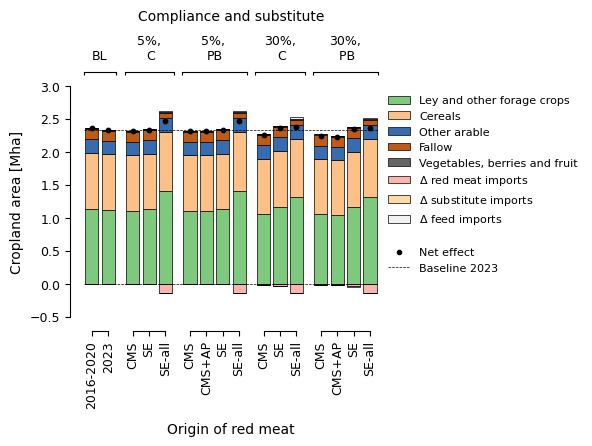

% change in Swedish cropland use:


Total cropland area Sweden:


In [63]:
from matplotlib.colors import ListedColormap
colors = [plt.colormaps['Accent'](i/4) for i in range(5)]\
+ [plt.colormaps['Pastel1'](i/2) for i in range(3)]

d = (
    session.get_attr('c','area',{'crop':['land_use','crop_group2']})
    .loc[:,'cropland']
    .sort_values(axis=1, by=('SLV','0'), ascending=False)
    .rename(columns={'Fodder crops':'Ley and other forage crops'})
    .join(food_import_land)
    .join(feed_import_land)
) / 1_000_000
d = d.set_index(make_scn_idx(d.index))

fig,ax = plt.subplots(figsize=(3.8,3))
cm.plot.bar(
    d,
    ax = ax,
    ylabel='Cropland area [Mha]',
    ylim=(-0.5,3),
    cmap=ListedColormap(name='X', colors=colors),
    **bar_style2
)
style_bar(ax, d)
legend_add_markers(ax)
plt.savefig('output/figs/cropland.png',dpi=200,bbox_inches='tight')
plt.show()
d.to_csv('output/cropland_Mha.csv')

t = d.iloc[:,0:5].sum(axis=1)
t = (t-t.loc[scn_tuple(BL_SCN[1])]) / t.iloc[0] * 100
print('% change in Swedish cropland use:')
display(t.to_frame().style.format(precision=1))

print('Total cropland area Sweden:')
t = d.iloc[:,0:5].sum(axis=1)
display(t.to_frame().style.format(precision=1))

In [13]:
session.get_attr('c','area','crop').loc[:,'Fallow']/1_000

scn  year
SLV  0       152.163263
     1       152.193077
     1110    152.201922
     1120    152.233051
     1121    152.235793
     1210    152.189314
     1220    152.217532
     1310     75.803296
     1320     75.804313
     2110    152.251125
     2120    152.659097
     2121    152.733260
     2210    152.184928
     2220    152.415438
     2310     76.057717
     2320     76.084385
Name: Fallow, dtype: float64

In [14]:
session.get_attr('c','area','crop').loc[:,'Ley not harvested']/1_000

scn  year
SLV  0       50.860462
     1       50.878494
     1110    50.881005
     1120    50.893469
     1121    50.894600
     1210    50.876268
     1220    50.887158
     1310    10.098111
     1320    10.098483
     2110    50.896308
     2120    51.081520
     2121    51.118331
     2210    50.862725
     2220    50.961168
     2310    10.163269
     2320    10.167070
Name: Ley not harvested, dtype: float64

# Semi-natural grasslands

In [15]:
# % of pastures ley vs semi-natural pastures
(
    session.get_attr('c','area','crop')
    .loc[:,['Semi-natural pastures','Ley for grazing']]
    .rename(columns=lambda x: x.capitalize())
    .apply(lambda x: x/x.sum()*100, axis=1)
)

crop      Semi-natural pastures  Ley for grazing
scn year                                        
SLV 0                 52.975736        47.024264
    1                 53.100425        46.899575
    1110              53.184491        46.815509
    1120              53.178497        46.821503
    1121              53.774913        46.225087
    1210              53.039495        46.960505
    1220              53.034264        46.965736
    1310              47.854353        52.145647
    1320              47.854063        52.145937
    2110              53.454643        46.545357
    2120              53.398667        46.601333
    2121              57.128915        42.871085
    2210              52.554826        47.445174
    2220              52.508239        47.491761
    2310              48.680126        51.319874
    2320              48.675463        51.324537

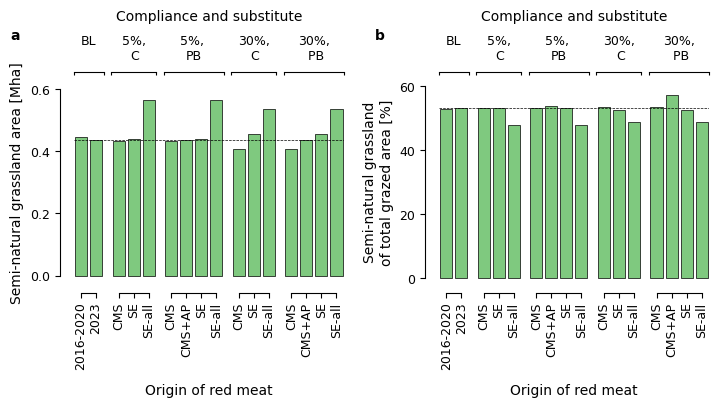

% change in SNG area from baseline:


% SNG of total grazed area:


Compliance  Origin, meat  Substitute
BL          2016-2020                   52.975736
            2023                        53.100425
5%          CMS           C             53.184491
                          PB            53.178497
            CMS+AP        PB            53.774913
            SE            C             53.039495
                          PB            53.034264
            SE-all        C             47.854353
                          PB            47.854063
30%         CMS           C             53.454643
                          PB            53.398667
            CMS+AP        PB            57.128915
            SE            C             52.554826
                          PB            52.508239
            SE-all        C             48.680126
                          PB            48.675463
Name: Semi-natural pastures, dtype: float64

In [67]:
fig,axs = plt.subplots(1,2, figsize=(8.2,2.5), gridspec_kw={'wspace':0.35})

d1 = (
    session.get_attr('c','area',{'crop':['land_use']})
    .loc[:,'semi-natural grasslands']
) / 1_000_000
d1.index = make_scn_idx(d1.index)
ax = axs[0]
ax, axgs = cm.plot.bar(
    d1,
    ax = ax,
    ylabel='Semi-natural grassland area [Mha]',
    **bar_style,
    ylim=(-0.01,0.61)
)
style_bar(ax, d1)
d1.to_csv('output/SNG_Mha.csv')

d2 = (
    session.get_attr('c','area','crop')
    .loc[:,['Semi-natural pastures','Ley for grazing']]
    .rename(columns=lambda x: x.capitalize())
    .apply(lambda x: x/x.sum()*100, axis=1)
    .loc[:,'Semi-natural pastures']
)
d2.index = make_scn_idx(d2.index)

ax = axs[1]
cm.plot.bar(
    d2,
    ax = ax,
    ylabel='Semi-natural grassland\nof total grazed area [%]',
    **bar_style,
    ylim = (-0.1,60)
)
style_bar(ax, d2)

annotate_axs(axs)
plt.savefig('output/figs/SNG.png',dpi=200,bbox_inches='tight')
plt.show()
t = (d1-d1.loc[scn_tuple(BL_SCN[1])]).div(d1.loc[scn_tuple(BL_SCN[1])]).mul(100)
print('% change in SNG area from baseline:')
display(t.to_frame().style.format(precision=1))

print('% SNG of total grazed area:')
display(d2)

# Animal numbers

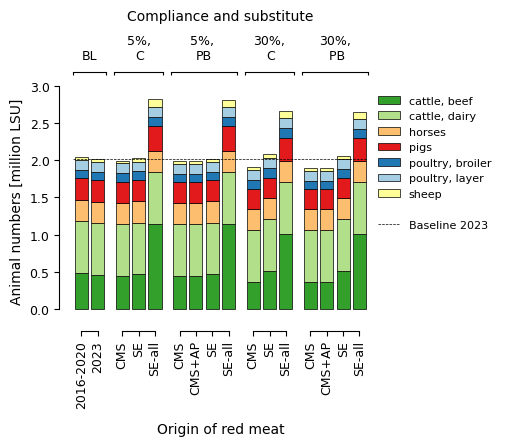

In [70]:
d = cm.impact.get_LSU(session, ['species','breed']) / 1_000_000
d.columns = pd.Index([sp if sp not in ['cattle','poultry'] else ', '.join([sp,br]) for sp,br in d.columns], name='type')
d = d.T.groupby('type').sum().T
d = d.set_index(make_scn_idx(d.index))

from matplotlib.colors import ListedColormap
colors = ['#33a02c','#b2df8a', '#fdbf6f', '#e31a1c', '#1f78b4','#a6cee3', '#ffff99']

fig,ax = plt.subplots(figsize=(3.8,3))
cm.plot.bar(
    d,
    ax = ax,
    ylabel='Animal numbers [million LSU]',
    cmap=ListedColormap(name='X', colors=colors),
    **bar_style2,
    ylim=(-0.1,3)
)
style_bar(ax, d)
legend_add_markers(ax, net=False)

plt.savefig('output/figs/LSU.png',dpi=200,bbox_inches='tight')
plt.show()
d.to_csv('output/LSU_million.csv')

In [18]:
# Total LSU
d.sum(axis=1)

Compliance  Origin, meat  Substitute
BL          2016-2020                   2.044462
            2023                        2.011498
5%          CMS           C             1.994290
                          PB            1.990937
            CMS+AP        PB            1.990937
            SE            C             2.022885
                          PB            2.019533
            SE-all        C             2.815196
                          PB            2.811843
30%         CMS           C             1.908205
                          PB            1.888096
            CMS+AP        PB            1.888174
            SE            C             2.079285
                          PB            2.059169
            SE-all        C             2.663429
                          PB            2.643313
dtype: float64

In [19]:
# Total LSU % change from 2023 baseline
d.sum(axis=1).pipe(lambda df: df.sub(df.loc[scn_tuple(BL_SCN[1])]).div(df.loc[scn_tuple(BL_SCN[1])])*100)

Compliance  Origin, meat  Substitute
BL          2016-2020                    1.638758
            2023                         0.000000
5%          CMS           C             -0.855516
                          PB            -1.022190
            CMS+AP        PB            -1.022187
            SE            C              0.566096
                          PB             0.399422
            SE-all        C             39.955145
                          PB            39.788471
30%         CMS           C             -5.135130
                          PB            -6.134831
            CMS+AP        PB            -6.130965
            SE            C              3.369955
                          PB             2.369909
            SE-all        C             32.410196
                          PB            31.410149
dtype: float64

In [20]:
# % change from 2023 baseline per animal category
display((d-d.loc[scn_tuple(BL_SCN[1])]).div(d.loc[scn_tuple(BL_SCN[1])], axis=1).mul(100).style.format(precision=1))

In [21]:
d = session.get_attr('g','x_animals',['species','sub_system']).loc[:,'sheep']

display(100-d.pipe(lambda df: df.div(df.sum(axis=1), axis=0)*100)['other sheep'])
d.drop('other sheep', axis=1)\
.pipe(lambda df: df.div(df.sum(axis=1), axis=0)*100)\
.pipe(lambda df: df.sub(df.loc[BL_SCN], axis=1))

scn  year
SLV  0       62.892595
     1       59.958365
     1110    59.560732
     1120    59.560726
     1121    59.560594
     1210    61.465243
     1220    61.465238
     1310    83.229282
     1320    83.229282
     2110    57.407131
     2120    57.389462
     2121    57.348677
     2210    67.406682
     2220    67.406682
     2310    81.999533
     2320    81.999533
Name: other sheep, dtype: float64

sub_system  autumn lamb  spring lamb  winter lamb
scn year                                         
SLV 0         -0.180218     0.100431     0.079787
    1          0.000000     0.000000     0.000000
    1110      -0.341664     0.190401     0.151263
    1120      -0.341669     0.190404     0.151265
    1121      -0.341783     0.190467     0.151316
    1210      -0.321844     0.179356     0.142488
    1220      -0.321849     0.179358     0.142490
    1310       3.118033    -0.188415    -2.929618
    1320       3.118033    -0.188415    -2.929618
    2110      -0.586425     0.326800     0.259625
    2120      -0.602362     0.335682     0.266680
    2121       2.651751    -2.934735     0.282983
    2210       3.560710     0.053045    -3.613754
    2220       3.560710     0.053045    -3.613754
    2310       3.092109    -0.202556    -2.889553
    2320       3.092109    -0.202556    -2.889553

# Climate impact

Default


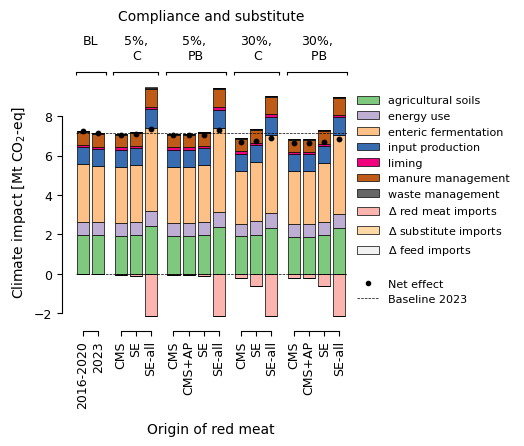

% change Swedish emissions from BL:


% change net emissions from BL:


Only Irish suckler cows


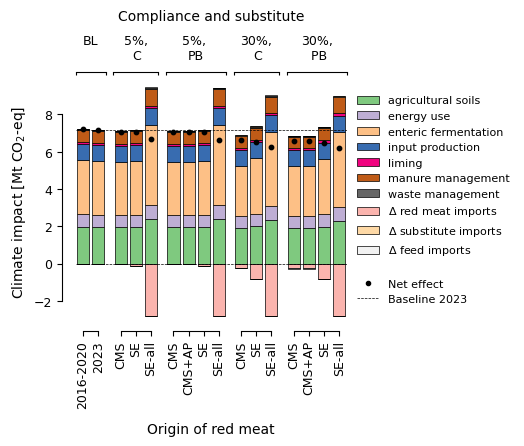

% change Swedish emissions from BL:


% change net emissions from BL:


In [71]:
from matplotlib.colors import ListedColormap

swe_clim_impact = (
    cm.impact.get_GHG(session, CO2eq=CO2e_method)
    .drop('organic soils', level='sub-process', axis=1)
    
    .T.groupby('process').sum().T
    .rename(columns={'waste and circularity':'waste management'})
) / 1_000_000_000
d = swe_clim_impact
d1 = (
    d
    .join(food_import_CO2e / 1_000_000_000)
    .join(feed_import_CO2e / 1_000_000_000)
)
d2 = (
    d
    .join(food_import_CO2e_sens / 1_000_000_000)
    .join(feed_import_CO2e / 1_000_000_000)
) 

swe_clim_impact.set_index(make_scn_idx(swe_clim_impact.index), inplace=True)
d1.set_index(make_scn_idx(d1.index), inplace=True)
d2.set_index(make_scn_idx(d2.index), inplace=True)

for dx in [d1,d2]:

    if dx is d1:
        print('Default')
        dx.to_csv('output/climate_MtCO2eq.csv')
    if dx is d2:
        print('Only Irish suckler cows')
        dx.to_csv('output/climate_Irish_beef_MtCO2eq.csv')
    len(dx.columns) - 3
    colors = [plt.colormaps['Accent'](i/(len(dx.columns)-3-1)) for i in range(len(dx.columns)-3)]\
        + [plt.colormaps['Pastel1'](i/2) for i in range(3)]
    
    fig,ax = plt.subplots(figsize=(3.5,3))
    ax,axgs = cm.plot.bar(
        dx,
        ax=ax,
        cmap=ListedColormap(name='X', colors=colors),
        ylabel='Climate impact [Mt CO$_2$-eq]',
        **bar_style2
    )
    style_bar(ax, dx)
    legend_add_markers(ax)
    
    plt.savefig(f'output/figs/climate{"_irish" if dx is d2 else ""}.png',dpi=200,bbox_inches='tight')
    plt.show()

    print('% change Swedish emissions from BL:')
    display((
        dx.iloc[:,:-3].sum(axis=1)
        / dx.loc[scn_tuple(BL_SCN[1])].sum() * 100 - 100
    ).to_frame().style.format(precision=2))

    print('% change net emissions from BL:')
    display((
        dx.sum(axis=1)
        / dx.loc[scn_tuple(BL_SCN[1])].sum() * 100 - 100
    ).to_frame().style.format(precision=2))

## Emissions per GHG

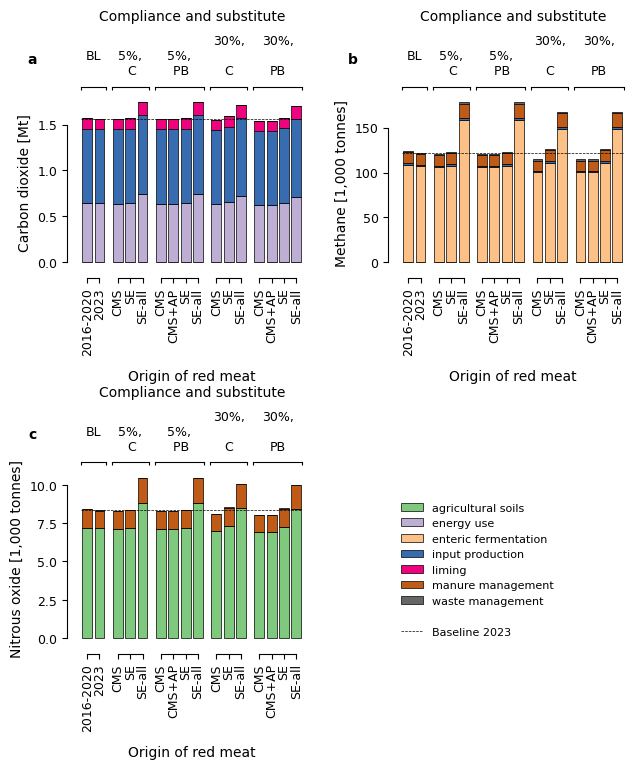

In [72]:
d = (
    cm.impact.get_GHG(session, CO2eq=False)
    .drop('organic soils', level='sub-process', axis=1)
    .rename(columns={'CH4bio':'CH4', 'CH4fos':'CH4','N2Oind':'N2O'})
    .T.groupby(['compound','process']).sum().T
    .rename(columns={'waste and circularity':'waste management'})
    .stack().fillna(0).unstack()
)
d.set_index(make_scn_idx(d.index), inplace=True)

fig, axs = plt.subplots(2,2, figsize=(7,7), gridspec_kw=dict(hspace=1.3, wspace=0.45))
axs = axs.flatten()

colors = [plt.colormaps['Accent'](i/(len(d.columns.unique('process'))-1)) for i in range(len(d.columns.unique('process')))]
labs = {
    'CO2' : 'Carbon dioxide [Mt]',
    'CH4' : 'Methane [1,000 tonnes]',
    'N2O' : 'Nitrous oxide [1,000 tonnes]',
}

factors = {
    'CO2' : 1 / 1_000_000_000, # Mt
    'CH4' : 1 / 1_000_000, # kt
    'N2O' : 1 / 1_000_000, # kt
}

for cmp,ax in zip(['CO2','CH4','N2O'], axs):
    dx = d.loc[:,cmp] * factors[cmp]
    cm.plot.bar(
        dx,
        cmap=ListedColormap(name='X', colors=colors),
        ylabel=labs[cmp],
        **bar_style2,
        ax=ax
    )
    style_bar(ax, dx)
    if ax != axs[2]:
        ax.legend().set_visible(False)
    else:
        ax.legend(
            ncol=1, fontsize=8, reverse=True,
            bbox_to_anchor=(1.4,0.9), frameon=False
        )
        legend_add_markers(ax, net=False, bbox_to_anchor=(1.4,0.9))

axs[-1].axis('off')
annotate_axs(axs[0:-1])

# plt.tight_layout()
plt.savefig('output/figs/GHG.png',dpi=200,bbox_inches='tight')
plt.show()

## Land use change

In [24]:
beef_cw = food_import_chg['Bovine meat and products'] / 0.695
beef_Ireland_LUC = beef_cw * 0.08 # 0.08 kg CO2/kgCW (Moberg et al. 2019)
beef_LatAm_LUC = beef_cw * 43 # 43 kg CO2/kgCW (Pendrill et al. 2019)
beef_import_LUC = pd.concat([beef_Ireland_LUC,beef_LatAm_LUC], axis=1)
beef_import_LUC.columns = ['Ireland','Latin America']
beef_import_LUC.index = make_scn_idx(beef_import_LUC.index)

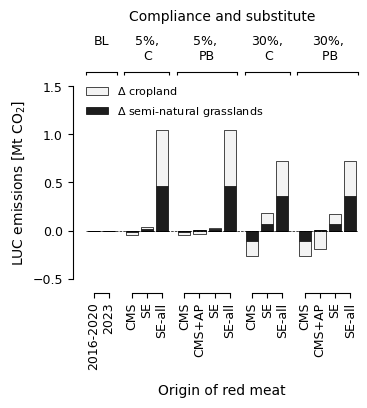

Total Swe LUC emissions:


Compliance  Origin, meat  Substitute
BL          2016-2020                   0.000000
            2023                        0.000000
5%          CMS           C            -0.042644
                          PB           -0.043608
            CMS+AP        PB           -0.031399
            SE            C             0.031816
                          PB            0.030854
            SE-all        C             1.042201
                          PB            1.041235
30%         CMS           C            -0.259832
                          PB           -0.265029
            CMS+AP        PB           -0.191563
            SE            C             0.181632
                          PB            0.175000
            SE-all        C             0.726691
                          PB            0.721151
dtype: float64

Swe LUC emission % of GHG emissions


Compliance  Origin, meat  Substitute
BL          2016-2020                    0.000000
            2023                         0.000000
5%          CMS           C             -0.600887
                          PB            -0.614944
            CMS+AP        PB            -0.442789
            SE            C              0.443229
                          PB             0.430162
            SE-all        C             11.066205
                          PB            11.062423
30%         CMS           C             -3.784966
                          PB            -3.879524
            CMS+AP        PB            -2.804185
            SE            C              2.473390
                          PB             2.394417
            SE-all        C              8.079176
                          PB             8.047651
dtype: float64

LUC [Mt CO2] from changed beef imports


Ireland  Latin America
Compliance Origin, meat Substitute                         
BL         2016-2020                0.000000       0.000000
           2023                     0.000000       0.000000
5%         CMS          C          -0.000061      -0.032788
                        PB         -0.000061      -0.032788
           CMS+AP       PB         -0.000061      -0.032788
           SE           C          -0.000194      -0.104067
                        PB         -0.000194      -0.104067
           SE-all       C          -0.003872      -2.081340
                        PB         -0.003872      -2.081340
30%        CMS          C          -0.000366      -0.196729
                        PB         -0.000366      -0.196729
           CMS+AP       PB         -0.000366      -0.196729
           SE           C          -0.001162      -0.624402
                        PB         -0.001162      -0.624402
           SE-all       C          -0.003872      -2.081340
                        PB         -0.003872      -2.081340

In [74]:
fig,ax = plt.subplots(figsize=(3.5,2.5))

d1 = swe_LUC.rename(
    {'$\Delta$ semi-natural grasslands':
     '$\Delta$ semi-natural\ngrasslands'}
    , axis=1
) / 1_000_000_000
d1 = swe_LUC.iloc[:,[1,0]] / 1_000_000_000
d1.index = make_scn_idx(d1.index)

cm.plot.bar(
    d1,
    ax=ax,
    ylabel='LUC emissions [Mt CO$_2$]',
    **bar_style2,
    totmarker='none',
    cmap='Greys',
    ylim = (-0.5,1.5)
)
ax.legend(
    ncol=1, fontsize=8, reverse=True,
    bbox_to_anchor=(-0.04,0.92), frameon=False,
    loc = 'center left'
)
plt.savefig('output/figs/LUC.png',dpi=200,bbox_inches='tight')
plt.show()
d1.to_csv('output/LUC_Swe_MtCO2.csv')

print('Total Swe LUC emissions:')
display(d1.sum(axis=1))
print('Swe LUC emission % of GHG emissions')
display(d1.sum(axis=1)/swe_clim_impact.sum(axis=1)*100)
print('LUC [Mt CO2] from changed beef imports')
display(beef_import_LUC * (10/20) / 1_000_000_000)

# Ammonia

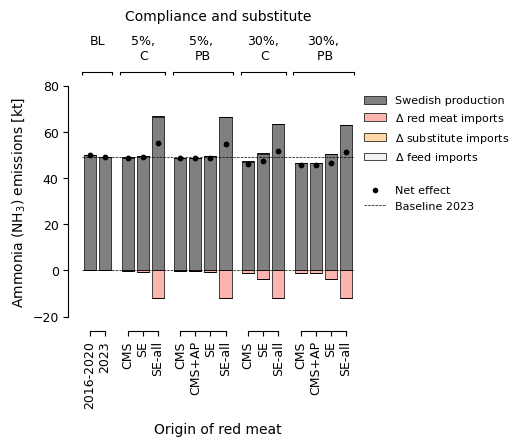

% change Swedish emissions:


% change net emissions:


In [73]:
from matplotlib.colors import ListedColormap
colors = ['grey']\
+ [plt.colormaps['Pastel1'](i/2) for i in range(3)]

d = (
    cm.impact.get_emissions(session)
    .drop('organic soils', level='sub-process', axis=1)
    .rename(columns={'waste and circularity':'waste management'})
    .T.groupby('compound').sum().loc['NH3-N'].T
    .mul((14+3)/14)
    .rename('Swedish production').to_frame()
    .join(food_import_ammonia)
    .join(feed_import_ammonia)
     / 1_000_000
)
d.set_index(make_scn_idx(d.index), inplace=True)

fig,ax = plt.subplots(figsize=(3.5,3))
cm.plot.bar(
    d,
    ax = ax,
    ylabel='Ammonia (NH$_3$) emissions [kt]',
    cmap=ListedColormap(name='X', colors=colors),
    ylim = (-20,80),
    **bar_style2
)
style_bar(ax, d)
legend_add_markers(ax)

d.to_csv('output/NH3_kt.csv')
plt.savefig('output/figs/NH3.png',dpi=200,bbox_inches='tight')
plt.show()

print('% change Swedish emissions:')
display((
    d.iloc[:,:-3].sum(axis=1)
    / d.loc[scn_tuple(BL_SCN[1])].sum() * 100 - 100
).to_frame().style.format(precision=2))

print('% change net emissions:')
display((
    d.sum(axis=1)
    / d.loc[scn_tuple(BL_SCN[1])].sum() * 100 - 100
).to_frame().style.format(precision=2))

# Fertilisers

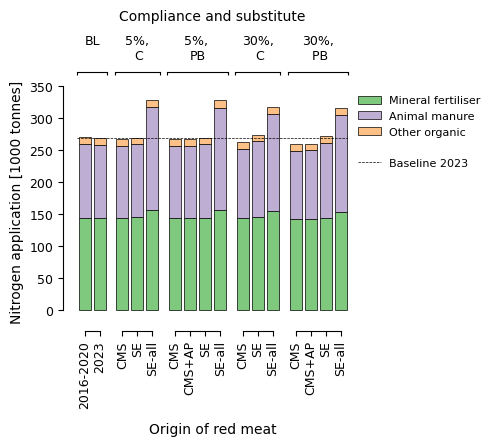

Change in total N-application:


Change in mineral N-application:


In [75]:
d = pd.concat([
    session.get_attr('c','fertiliser.mineral_N','none').rename('Mineral fertiliser'),
    session.get_attr('c','fertiliser.manure_N','none').rename('Animal manure'),
    session.get_attr('c','fertiliser.organic_N','none').rename('Other organic')
], axis=1) / 1_000_000
d.index = make_scn_idx(d.index)

fig,ax = plt.subplots(figsize=(3.5,3))
cm.plot.bar(
    d,
    ax = ax,
    ylabel='Nitrogen application [1000 tonnes]',
    ylim=(-10,350),
    **bar_style
)
style_bar(ax, d)
legend_add_markers(ax, net=False)

d.to_csv('output/N_fert_ktN.csv')
plt.savefig('output/figs/N_fert.png',dpi=200,bbox_inches='tight')
plt.show()

print('Change in total N-application:')
display((
    d.sum(axis=1)
    / d.loc[scn_tuple(BL_SCN[1])].sum() * 100 - 100
).to_frame().style.format(precision=2))

print('Change in mineral N-application:')
display((
    d.loc[:,'Mineral fertiliser']
    / d.loc[:,'Mineral fertiliser'].loc[scn_tuple(BL_SCN[1])].sum() * 100 - 100
).to_frame().style.format(precision=2))

In [9]:
d.loc[:,'Mineral fertiliser']

Compliance  Origin, meat  Substitute
BL          2016-2020                   144.462411
            2023                        144.217053
5%          CMS           C             144.095277
                          PB            143.856333
            CMS+AP        PB            143.886349
            SE            C             144.504909
                          PB            144.266286
            SE-all        C             156.649216
                          PB            156.415555
30%         CMS           C             143.481873
                          PB            142.024128
            CMS+AP        PB            142.206185
            SE            C             145.789916
                          PB            144.324362
            SE-all        C             155.005832
                          PB            153.602839
Name: Mineral fertiliser, dtype: float64

# Maps

In [13]:
def rescale_colormap(cmap, min_val=0.0, max_val=1.0):
    import matplotlib.pyplot as plt
    import matplotlib.colors as colors
    if isinstance(cmap, str):
        cmap = plt.get_cmap(cmap)
    return colors.LinearSegmentedColormap.from_list(
        "new_cmap", cmap(np.linspace(min_val, max_val, 256))
    )

map_style1 = {
    'cmap' : 'BrBG',
    'edgecolor' : 'grey'
}
map_style2 = {
    'cmap' : rescale_colormap('BrBG',0.5,1),
    'edgecolor' : 'grey'
}



## Total Cropland and Semi-natural grasslands

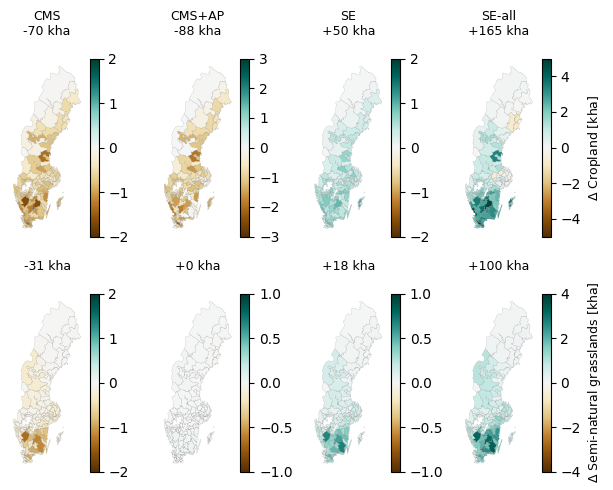

In [14]:
d = (
    session.get_attr('c','area',{'crop':'land_use', 'region':None})
    .drop('greenhouse', axis=1)
    .pipe(lambda df: df.sub(df.loc[BL_SCN], axis=1))
    .droplevel('scn')
) / 1_000

scns = ['2120','2121','2220','2320']

fig, axs = plt.subplots(2,len(scns), figsize=(1.6*len(scns),5))#, gridspec_kw={'width_ratios':(1,)*(len(scns)-1)+(1.1,)})
for i, lu in enumerate(d.columns.unique('land_use')):
    for j, scn in enumerate(scns): 
        ax = axs[i,j]
        map_data = d.loc[scn,lu]
        lim = np.ceil(map_data.abs().max().max())
        cm.plot.map_from_series(
            map_data,
            ax=ax,
            vmin = -lim,
            vmax = lim,
            **map_style1
        )
        ax.axis('off')
        title_str = ''
        if i == 0:
            title_str += scn_tuple(scn)[1] + '\n'
        title_str += f'{map_data.sum():+.0f} kha'
        ax.set_title(title_str, size=9)
        
        if scn == scns[-1]:
            cbar = ax.get_figure().axes[-1]
            cbar.set_ylabel(f'$\Delta$ {lu.capitalize()} [kha]', fontsize=9)
        

plt.tight_layout()
plt.savefig('output/figs/map_land_use.png',dpi=200,bbox_inches='tight')
plt.show()

## Different crops

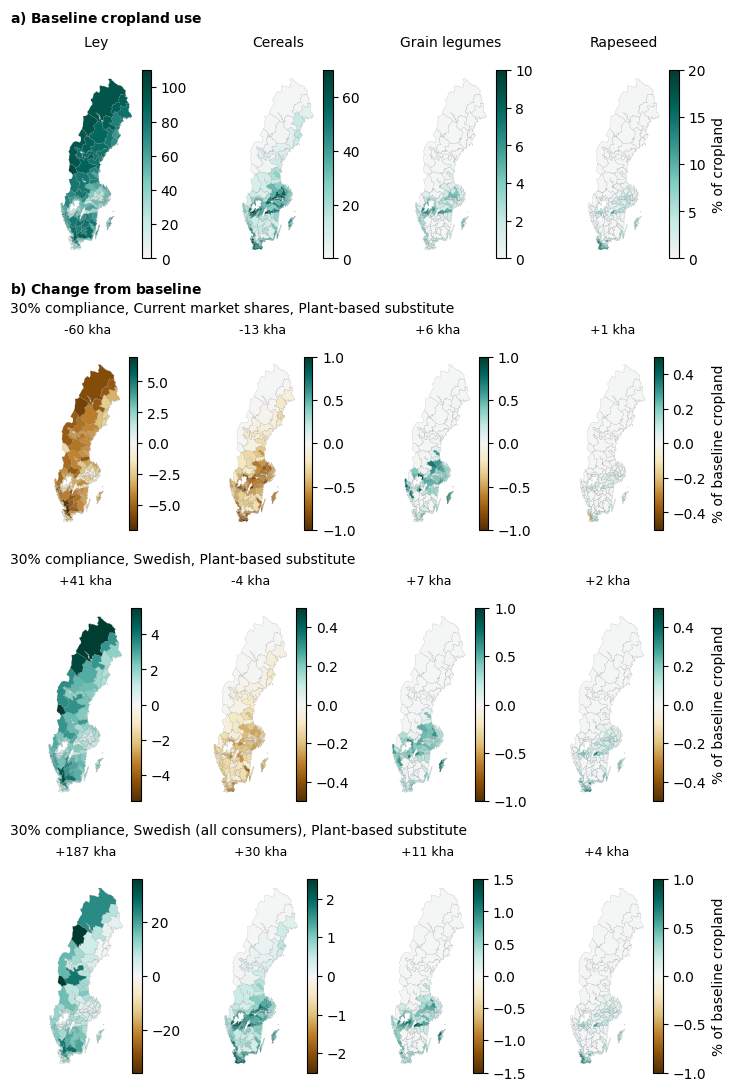

In [15]:
scns = ['2120','2220','2320']
scn_titles = {0 : r'$\bf{a)}$ $\bf{Baseline}$ $\bf{cropland}$ $\bf{use}$'}

for i, scn in enumerate(scns):
    if i == 0:
        title_str = r'$\bf{b)}$ $\bf{Change}$ $\bf{from}$ $\bf{baseline}$'+'\n'
    else:
        title_str = ''
    tpl = scn_tuple(scn, long=True)
    title_str += f'{tpl[0]} compliance, {tpl[1]}, {tpl[2]} substitute'.replace("\n","")
    scn_titles.update(
        {i+1:title_str}
    )

plot_data = (
    session.get_attr('C', 'area', {'crop':['land_use','crop_group'], 'region':None})
    .loc['SLV','cropland']
    .T
    .rename({'Cereals, winter':'Cereals', 'Cereals, spring':'Cereals'})
    .groupby(['crop_group','region'])
    .sum()
)

plot_data1_nat = plot_data.groupby('crop_group').sum()/1000
plot_data1 = plot_data.div(plot_data.groupby('region').sum()[BL_SCN[1]], axis=0) * 100

plot_data2 = plot_data1.sub(plot_data1[BL_SCN[1]], axis=0)
plot_data2_nat = plot_data1_nat.sub(plot_data1_nat[BL_SCN[1]], axis=0)

crps = ['Ley','Cereals','Grain legumes','Brassicaceae']

h = 2.7
w = 1.8
fig = plt.figure(constrained_layout=True, figsize=(w*len(crps), h+h*len(scns)))
# fig.suptitle('Figure title')

# create 3x1 subfigs
subfigs = fig.subfigures(nrows=len(scns)+1, ncols=1)
for row, subfig in enumerate(subfigs):
    
    axs = subfig.subplots(nrows=1, ncols=len(crps))
    subfig.suptitle(scn_titles[row], x=0, ha='left', size=10)
    if row==0:
        for crp, ax in zip(crps,axs):
            map_data = plot_data1['0'].loc[crp]
            lim = np.ceil(map_data.max()/10)*10
            leg_str = '% of cropland' if crp==crps[-1] else ''
            plot.map_from_series(map_data, vmin=0, vmax=lim, **map_style2, ax=ax, legend_kwds={'label': leg_str})
            ax.axis('off')
            ax.set_title('Rapeseed' if crp == 'Brassicaceae' else '   Ley   ' if crp=='Ley' else crp, size=10)
        
    else:
        scn = scns[row-1]
        for crp, ax in zip(crps,axs):
            map_data = plot_data2[scn].loc[crp]
            # lim = np.ceil(abs(plot_data2[scns].loc[crp]).quantile(0.99).max())
            lim = np.ceil(abs(map_data).quantile(0.99).max()*2)/2
            leg_str = '% of baseline cropland' if crp==crps[-1] else ''
            plot.map_from_series(map_data, vmin=-lim, vmax=lim, **map_style1, ax=ax, legend_kwds={'label': leg_str})
            ax.axis('off')
            nat_chg = plot_data2_nat[scn][crp]
            ax.set_title(f'{nat_chg:+.0f} kha', size=9)

plt.savefig('output/figs/map_per_crop.png',dpi=200,bbox_inches='tight')
plt.show()

In [16]:
# Changes in crop areas [1000 ha]
t1 = plot_data1_nat.T.pipe(lambda df: df.sub(df.loc['1'], axis=1))
t1.index = make_scn_idx(t1.index)
t1 = pd.concat({' 1000 ha': t1}, names=['unit'], axis=1)

t2 = plot_data1_nat.T.pipe(lambda df: df.sub(df.loc['1'], axis=1).div(df.loc['1'], axis=1)*100)
t2.index = make_scn_idx(t2.index)
t2 = pd.concat({'%': t2}, names=['unit'], axis=1)

t = pd.concat([t1,t2], axis=1).T.groupby(['crop_group','unit']).sum().T
t[['Ley','Cereals','Brassicaceae','Grain legumes']]

crop_group                                 Ley               Cereals  \
unit                                   1000 ha          %    1000 ha   
Compliance Origin, meat Substitute                                     
BL         2016-2020                 17.751682   1.705609   2.389292   
           2023                       0.000000   0.000000   0.000000   
5%         CMS          C           -10.092600  -0.969713  -0.629900   
                        PB          -10.086566  -0.969133  -2.178324   
           CMS+AP       PB          -13.060338  -1.254858  -2.174685   
           SE           C             7.195679   0.691372   0.784985   
                        PB            7.196888   0.691488  -0.762381   
           SE-all       C           272.422911  26.174820  46.222398   
                        PB          272.417648  26.174314  44.707118   
30%        CMS          C           -59.750999  -5.740970  -3.765267   
                        PB          -59.672767  -5.733453 -13.169591   
           CMS+AP       PB          -77.154046  -7.413081 -13.090802   
           SE           C            41.735212   4.009984   5.174082   
                        PB           41.388796   3.976700  -3.972132   
           SE-all       C           187.215998  17.988006  38.836775   
                        PB          187.224320  17.988806  29.905451   

crop_group                                   Brassicaceae            \
unit                                       %      1000 ha         %   
Compliance Origin, meat Substitute                                    
BL         2016-2020                0.283252    -0.185612 -0.225411   
           2023                     0.000000     0.000000  0.000000   
5%         CMS          C          -0.074675     0.335676  0.407653   
                        PB         -0.258241     0.122707  0.149018   
           CMS+AP       PB         -0.257810     0.119285  0.144863   
           SE           C           0.093060     0.499944  0.607144   
                        PB         -0.090381     0.287085  0.348644   
           SE-all       C           5.479686     3.755942  4.561308   
                        PB          5.300049     3.543557  4.303382   
30%        CMS          C          -0.446374     2.008522  2.439198   
                        PB         -1.561261     0.728676  0.884922   
           CMS+AP       PB         -1.551920     0.705894  0.857255   
           SE           C           0.613390     3.466362  4.209634   
                        PB         -0.470898     2.294367  2.786335   
           SE-all       C           4.604117     5.322240  6.463458   
                        PB          3.545304     4.068064  4.940357   

crop_group                         Grain legumes             
unit                                     1000 ha          %  
Compliance Origin, meat Substitute                           
BL         2016-2020                    0.615424   1.112217  
           2023                         0.000000   0.000000  
5%         CMS          C              -0.355956  -0.643296  
                        PB              0.990949   1.790881  
           CMS+AP       PB              0.994152   1.796669  
           SE           C              -0.150129  -0.271319  
                        PB              1.196125   2.161683  
           SE-all       C               5.632011  10.178383  
                        PB              6.939360  12.541075  
30%        CMS          C              -2.139305  -3.866232  
                        PB              6.068641  10.967477  
           CMS+AP       PB              6.083103  10.993614  
           SE           C              -1.131180  -2.044311  
                        PB              6.894793  12.460530  
           SE-all       C               3.333796   6.024962  
                        PB             11.207835  20.255224

In [24]:
t = plot_data.groupby('crop_group').sum().apply(lambda x: x/x.sum()*100, axis=0).T
t.index = make_scn_idx(t.index)
t

crop_group                           Berries  Brassicaceae    Cereals  \
Compliance Origin, meat Substitute                                      
BL         2016-2020                0.131909      3.494692  35.981943   
           2023                     0.133149      3.535502  36.217496   
5%         CMS          C           0.133811      3.567605  36.370795   
                        PB          0.133831      3.558950  36.309437   
           CMS+AP       PB          0.134004      3.563391  36.356408   
           SE           C           0.132644      3.543519  36.114137   
                        PB          0.132665      3.534954  36.053456   
           SE-all       C           0.119437      3.320131  34.309974   
                        PB          0.119459      3.312491  34.257223   
30%        CMS          C           0.137168      3.731460  37.148136   
                        PB          0.137268      3.677540  36.759063   
           CMS+AP       PB          0.138333      3.705081  37.048029   
           SE           C           0.130227      3.603888  35.644000   
                        PB          0.130356      3.558104  35.293984   
           SE-all       C           0.124243      3.512158  35.350009   
                        PB          0.124364      3.465264  35.026074   

crop_group                          Energy crops    Fallow  Fodder crops  \
Compliance Origin, meat Substitute                                         
BL         2016-2020                    0.368373  6.472457      3.180485   
           2023                         0.371946  6.534562      3.152426   
5%         CMS          C               0.373842  6.567507      3.132901   
                        PB              0.373998  6.569837      3.134047   
           CMS+AP       PB              0.374489  6.578426      3.137358   
           SE           C               0.370537  6.509694      3.162538   
                        PB              0.370684  6.511896      3.163662   
           SE-all       C               0.331953  2.923094      3.319809   
                        PB              0.332019  2.923618      3.320138   
30%        CMS          C               0.383487  6.735093      3.030836   
                        PB              0.384954  6.758094      3.040461   
           CMS+AP       PB              0.388154  6.813883      3.059862   
           SE           C               0.363861  6.391539      3.199338   
                        PB              0.364880  6.407413      3.202889   
           SE-all       C               0.346914  3.047104      3.280038   
                        PB              0.347404  3.051123      3.276597   

crop_group                          Fruit trees  Grain legumes  Green manure  \
Compliance Origin, meat Substitute                                             
BL         2016-2020                   0.071898       2.379840      0.150087   
           2023                        0.072576       2.375780      0.151556   
5%         CMS          C              0.072937       2.372260      0.152383   
                        PB             0.072950       2.430744      0.152883   
           CMS+AP       PB             0.073044       2.434016      0.153113   
           SE           C              0.072301       2.360376      0.150900   
                        PB             0.072313       2.418330      0.151365   
           SE-all       C              0.065235       2.350909      0.135139   
                        PB             0.065244       2.401721      0.135161   
30%        CMS          C              0.074774       2.353118      0.156641   
                        PB             0.074846       2.718203      0.162635   
           CMS+AP       PB             0.075430       2.739957      0.164754   
           SE           C              0.070987       2.276398      0.148218   
                        PB             0.071067       2.616005      0.151614   
           SE-all       C           

In [ ]:
# Share of cropland used per crop group
t = (plot_data.loc['Grain legumes'] / plot_data.groupby('region').sum() * 100).apply(lambda x: pd.Series({
    'mean':x.mean(),
    'max':x.max(),
    'Sweden':(plot_data.loc['Grain legumes'].sum() / plot_data.sum() * 100)[x.name]
})).T

In [32]:
# Share of grain legumes of cropland
t = (plot_data.loc['Grain legumes'] / plot_data.groupby('region').sum() * 100).apply(lambda x: pd.Series({
    'mean':x.mean(),
    'max':x.max(),
    'Sweden':(plot_data.loc['Grain legumes'].sum() / plot_data.sum() * 100)[x.name]
})).T
t.index = make_scn_idx(t.index)
t

mean       max    Sweden
Compliance Origin, meat Substitute                              
BL         2016-2020                1.723741  6.757382  2.379840
           2023                     1.719921  6.705119  2.375780
5%         CMS          C           1.716621  6.672342  2.372260
                        PB          1.763092  6.744417  2.430744
           CMS+AP       PB          1.765950  6.747232  2.434016
           SE           C           1.708506  6.679460  2.360376
                        PB          1.754531  6.751250  2.418330
           SE-all       C           1.723053  6.890712  2.350909
                        PB          1.760867  6.979429  2.401721
30%        CMS          C           1.699270  6.507082  2.353118
                        PB          1.997386  6.945649  2.718203
           CMS+AP       PB          2.019076  6.972939  2.739957
           SE           C           1.649278  6.501724  2.276398
                        PB          1.919261  6.949167  2.616005
           SE-all       C           1.716511  6.767652  2.350373
                        PB          1.956788  7.285999  2.668412

## Share of max land use

In [33]:
max_lu = session.get_attr('r','max_land_use',['land_use','region'])
lu = session.get_attr('c','area',{'crop':'land_use', 'region':None})
d = (
    (lu/max_lu)
    .clip(upper=0.999)
    .replace({0.999:np.nan})
    .drop('greenhouse', axis=1)
    .droplevel('scn')
) * 100

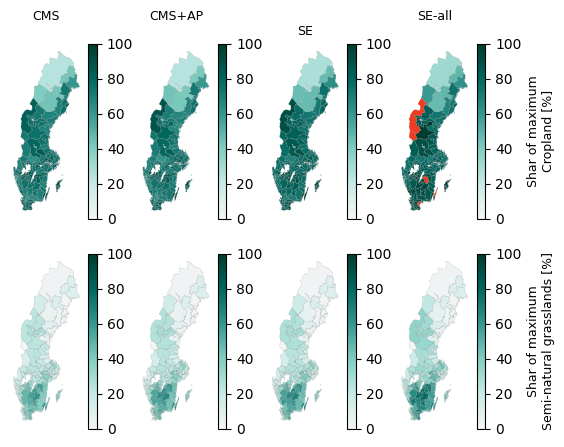

In [34]:
scns = ['2120','2121','2220','2320']

fig, axs = plt.subplots(2,len(scns), figsize=(1.6*len(scns),5))#, gridspec_kw={'width_ratios':(1,)*(len(scns)-1)+(1.1,)})
for i, lu in enumerate(d.columns.unique('land_use')):
    for j, scn in enumerate(scns): 
        ax = axs[i,j]
        map_data = d.loc[scn,lu]
        lim = np.ceil(map_data.abs().max().max())
        cm.plot.map_from_series(
            map_data,
            ax=ax,
            vmin=0,
            vmax=100,
            missing_kwds={"color": "#f03b20"},
            **map_style2
        )
        ax.axis('off')
        if i == 0:
            ax.set_title(scn_tuple(scn)[1], size=9)
        
        if scn == scns[-1]:
            cbar = ax.get_figure().axes[-1]
            cbar.set_ylabel(f'Shar of maximum\n{lu.capitalize()} [%]', fontsize=9)
        

# plt.tight_layout()
plt.show()

# Use of cereals

In [35]:
d = (
    session.get_attr('c','production_per_use',{'crop':'crop_group2','demand':None})
    .loc[:,'Cereals']
    .rename(columns=lambda x: 'feed' if 'feed' in x else x)
    .T.groupby('demand').sum().T
    .apply(lambda x: x/x.sum()*100, axis=1)
)
d.set_index(make_scn_idx(d.index), inplace=True)
d['food+export'] = d['food'] + d['export']
d

demand                                 export       feed       food  \
Compliance Origin, meat Substitute                                    
BL         2016-2020                26.759454  41.029055  16.482907   
           2023                     26.825669  40.892238  16.523694   
5%         CMS          C           26.837822  40.867653  16.531179   
                        PB          26.893747  40.751002  16.565628   
           CMS+AP       PB          26.893578  40.751361  16.565523   
           SE           C           26.795010  40.956321  16.504809   
                        PB          26.850760  40.840030  16.539149   
           SE-all       C           25.477277  43.687831  15.693130   
                        PB          25.527247  43.583488  15.723910   
30%        CMS          C           26.898283  40.745364  16.568422   
                        PB          27.239349  40.034435  16.778507   
           CMS+AP       PB          27.235635  40.042329  16.776219   
           SE           C           26.626240  41.309169  16.400852   
                        PB          26.955226  40.622952  16.603496   
           SE-all       C           25.651274  43.329877  15.800307   
                        PB          25.953243  42.699391  15.986309   

demand                               non-food      seed  food+export  
Compliance Origin, meat Substitute                                    
BL         2016-2020                12.293837  3.434747    43.242361  
           2023                     12.324257  3.434142    43.349363  
5%         CMS          C           12.329841  3.433506    43.369001  
                        PB          12.355534  3.434089    43.459375  
           CMS+AP       PB          12.355456  3.434081    43.459102  
           SE           C           12.310172  3.433687    43.299819  
                        PB          12.335785  3.434276    43.389909  
           SE-all       C           11.704779  3.436983    41.170407  
                        PB          11.727736  3.437620    41.251157  
30%        CMS          C           12.357618  3.430313    43.466705  
                        PB          12.514311  3.433399    44.017856  
           CMS+AP       PB          12.512604  3.433214    44.011853  
           SE           C           12.232636  3.431103    43.027093  
                        PB          12.383779  3.434547    43.558722  
           SE-all       C           11.784717  3.433825    41.451581  
                        PB          11.923447  3.437609    41.939553

# TEST SAFAD

In [36]:
if False:
    codes = pd.read_csv('SAFAD_data/SAFAD IP Recipes.csv')['Food code'].unique()
    len(codes)
    
    for c in codes:
        try:
            print(c,end=': ')
            print(round(
                SAFAD.get_footprints(c)['Carbon footprint, primary production'] /
                SAFAD.get_GHG(c, CO2eq='GWP100 AR6').drop('Transport', level='process').sum(),
                2
            ))
        except:
            print('Failed')